In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, sys
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

from hmmlearn import hmm
osp = sys.platform

from utilities import *
from helpers import *
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %%time
game_id = '0021500463'
game_data = Data.load_game(game_id)
events_df = pd.DataFrame(game_data['events'])
print('raw events shape:', events_df.shape)
events_df.head(3)

raw events shape: (231, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,702.31,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[0],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,686.28,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[1],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
2,668.42,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351444029, 692.25, 12.21, None, [[-1,...","[2, 3]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,692.25,"{'abbreviation': 'TOR', 'players': [{'playerid..."


In [3]:
# get events and number of events
# events_df = pd.DataFrame(data['events'])
# n_events = events_df.shape[0]
# # get numebr of moments
# moments = events_df.iloc[event_number,:]['moments']
# n_moments = len(moments)

# print(n_moments, event_df.shape)
# event_df.head()

In [4]:
# # get all the player_id and player_name mapping
# player_id_mapping = id_player(event_df)

In [5]:
# get position mapping
# get all the player_id and player_name mapping
id_position_mapping = id_position(events_df)

In [6]:
# set(np.concatenate(list(position_id_mapping.values())))

In [7]:
# play id to play roles/positions
id_role = id_position(events_df)
check_game_roles_duplicates(id_role)

# we will use this fixed order as the role order
roles = ['F', 'G', 'C-F', 'G-F', 'F-G', 'C', 'F-C']
role_order = {'F': 0, 'G':4, 'C-F':1, 'G-F':3, 'F-G':3, 'C':2, 'F-C':1}

# its possible that F has similar role as G-f or F-G, we create empty slots to ensure meta order
# ddentify defending and offending runs (this is included in process_moments)
court_index = Data.load_csv('./meta_data/court_index.csv')
court_index = dict(zip(court_index.game_id, court_index.court_position))

# home and visitor ids
homeid = events_df.loc[0].home['teamid']
awayid = events_df.loc[0].visitor['teamid']

#### Pre-process 
filter events, subsample frames, add velocity, reorder moments, re-arrange team order
shot clock, filter out event with short moments

In [8]:
# filter out actions except 1: Make, 2: Miss, 4: Rebound, 6:Personal Foul, 7:Violation
use_event = [1, 2, 4, 6, 7]
discard_event = [3, 5, 8, 9, 10, 12, 13, 18]
events = filter_event_type(events_df, discard_event)
print('After filtering events has shape:', events.shape)
# break up sequences at 24secs shot clock point (or irregular case, e.g. out of bound maybe),
# and obtain the game data
subsample_factor = 0
single_game = get_game_data_ra(events, court_index, game_id, event_threshold=10, subsample_factor=subsample_factor)
print('Final number of events:', len(single_game))

After filtering events has shape: (134, 8)
Final number of events: 165


In [9]:
single_game[0].shape

(38, 30)

In [10]:
# create data s.t. its for all players        
seq_lens = np.array([len(i) for i in single_game])
train = np.concatenate(single_game, axis=0)

In [11]:
single_game[0].shape

(38, 30)

In [12]:
train.shape

(21119, 30)

In [13]:
final = []
final_players = []
for i in range(0, train.shape[1], 3):
    final.append(train[:,i+1:i+3])
    final_players.append(train[:, i])
    
final = np.concatenate(final, axis=0)
seq_lens = np.concatenate([seq_lens for _ in range(10)], axis=0)
final_players = np.concatenate(final_players)

In [14]:
# Viterbi is set by default as the 'algorithm' optional parameter.
model = hmm.GMMHMM(n_components=6, n_mix=5, verbose=True, n_iter=100)
model.fit(final, lengths=seq_lens)

         1    -1639835.3779             +nan
         2    -1597447.7205      +42387.6574
         3    -1594726.4223       +2721.2982
         4    -1592822.0074       +1904.4149
         5    -1591273.9547       +1548.0527
         6    -1589987.2488       +1286.7059
         7    -1588909.1522       +1078.0965
         8    -1588001.6915        +907.4607
         9    -1587234.5044        +767.1870
        10    -1586581.3511        +653.1534
        11    -1586019.1908        +562.1602
        12    -1585529.7426        +489.4483
        13    -1585101.0742        +428.6683
        14    -1584726.7466        +374.3276
        15    -1584402.9618        +323.7849
        16    -1584125.8132        +277.1486
        17    -1583890.0539        +235.7593
        18    -1583689.3525        +200.7014
        19    -1583517.1914        +172.1611
        20    -1583367.6533        +149.5381
        21    -1583235.8130        +131.8403
        22    -1583117.7910        +118.0219
        23

GMMHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
    init_params='stmcw', n_components=6, n_iter=100, n_mix=5,
    params='stmcw', random_state=None, startprob_prior=1.0, tol=0.01,
    transmat_prior=1.0, verbose=True)

In [15]:
state_sequence = model.predict(final, lengths=seq_lens)
# # prob_next_step = model.transmat_[state_sequence[-1], :]

In [16]:
state_sequence[:30]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [17]:
final_players[:30]

array([2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
       2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
       2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200., 2200.,
       2200., 2200., 2200.])

In [18]:
id_position_mapping[2200]

['C-F']

In [19]:
state_sequence[-10:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
final_players[-10:]

array([1626171., 1626171., 1626171., 1626171., 1626171., 1626171.,
       1626171., 1626171., 1626171., 1626171.])

In [21]:
id_position_mapping[1626171]

['F']

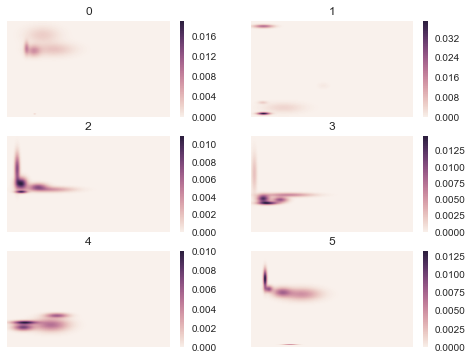

In [26]:
def gaussian_superposition(means_arr, vars_arr, mix_p):
    ''' means_arr: n_mix x feature_dim
        vars_arr: n_mix x feature_dim
    '''
    #Create grid and multivariate normal
    nx = 1000
    ny = 500
    x = np.linspace(0,94,nx)
    y = np.linspace(0,50,ny)

    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    
    def single_gaussian_(mu, var):
        #Parameters to set
        mu_x, mu_y = mu[0], mu[1]
        var_x, var_y = var[0], var[1]
        rv = multivariate_normal([mu_x, mu_y], [[var_x, 0], [0, var_y]])

        return rv.pdf(pos)
    n_mix = means_arr.shape[0]
    sp = np.sum([single_gaussian_(means_arr[i], vars_arr[i])*mix_p[i] for i in range(n_mix)],axis=0)
    return X, Y, sp, nx, ny

def plot_3d_gaussian(X,Y,Z):
    %matplotlib notebook
    %matplotlib notebook
    #Make a 3D plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z,cmap='viridis',linewidth=0)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

# plot all the 3ds
gmms = model.gmms_
nrows, ncols = 3, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,6))
n_state = 0
for i in range(nrows):
    for j in range(ncols):
        X, Y, Z, nx, ny = gaussian_superposition(gmms[n_state].means_, gmms[n_state].covars_, gmms[n_state].weights_)
        df = pd.DataFrame(Z, index=range(ny), columns=range(nx))
        sns.heatmap(df, ax=ax[i, j], xticklabels=False, yticklabels=False).set_title(str(n_state))
        n_state += 1

---

### Next: try using the predefined position as indexing mechanism for the imitation learning

Questions:

  - Is the latent structure learning trained for each individual agent or their sequences are put together?